Install:

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 744.8 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z0foa1xm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z0foa1xm
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [2]:
import numpy as np
import torch
from pkg_resources import packaging
import clip

clip.available_models() # see available models

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load("ViT-B/32") #choose which model to load

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 142MiB/s]


Text Preprocessing:

In [4]:
yourstringhere = "Hello"
clip.tokenize(yourstringhere)

tensor([[49406,  3306, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [30]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from torchvision import transforms

Get feature tensors in the cell below. Can look them up in map:

In [48]:
yourdirectoryhere = "/content"

image_ftrs = {}
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1]
])

for filename in [filename for filename in os.listdir(yourdirectoryhere) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]

    image_path = os.path.join(yourdirectoryhere, filename)
    image = Image.open(image_path).convert("RGB")
    preprocessed = (preprocess(image).unsqueeze(0)).cuda() #preprocess img here

    with torch.no_grad():
      ftrs = model.encode_image(preprocessed).float()
      image_ftrs[name] = ftrs

print("Got features for ", len(image_ftrs), " images.")

Got features for  1  images.


Cells below are for text and image similarity scores:

In [12]:

# images in skimage to use and their textual descriptions
# get text descriptions of images, formatted like below
"""
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
}
"""
descriptions = {"freiren_ending": "frieren"}

In [37]:
yourdirectoryhere = "/content"

original_images = [] #for plot down below
images = []
texts = []
print(os.listdir(yourdirectoryhere))
for filename in [filename for filename in os.listdir(yourdirectoryhere) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions: #file name must match key in desciption
        continue

    image_path = os.path.join(yourdirectoryhere, filename)
    image = Image.open(image_path).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image)) #preprocess img here
    texts.append(descriptions[name])

image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()


['.config', 'freiren_ending.png', '.ipynb_checkpoints', 'sample_data']


Cosine similarities with text and images:

In [46]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T


a and b are equal


Text(0.5, 1.0, 'Cosine similarity between text and image features')

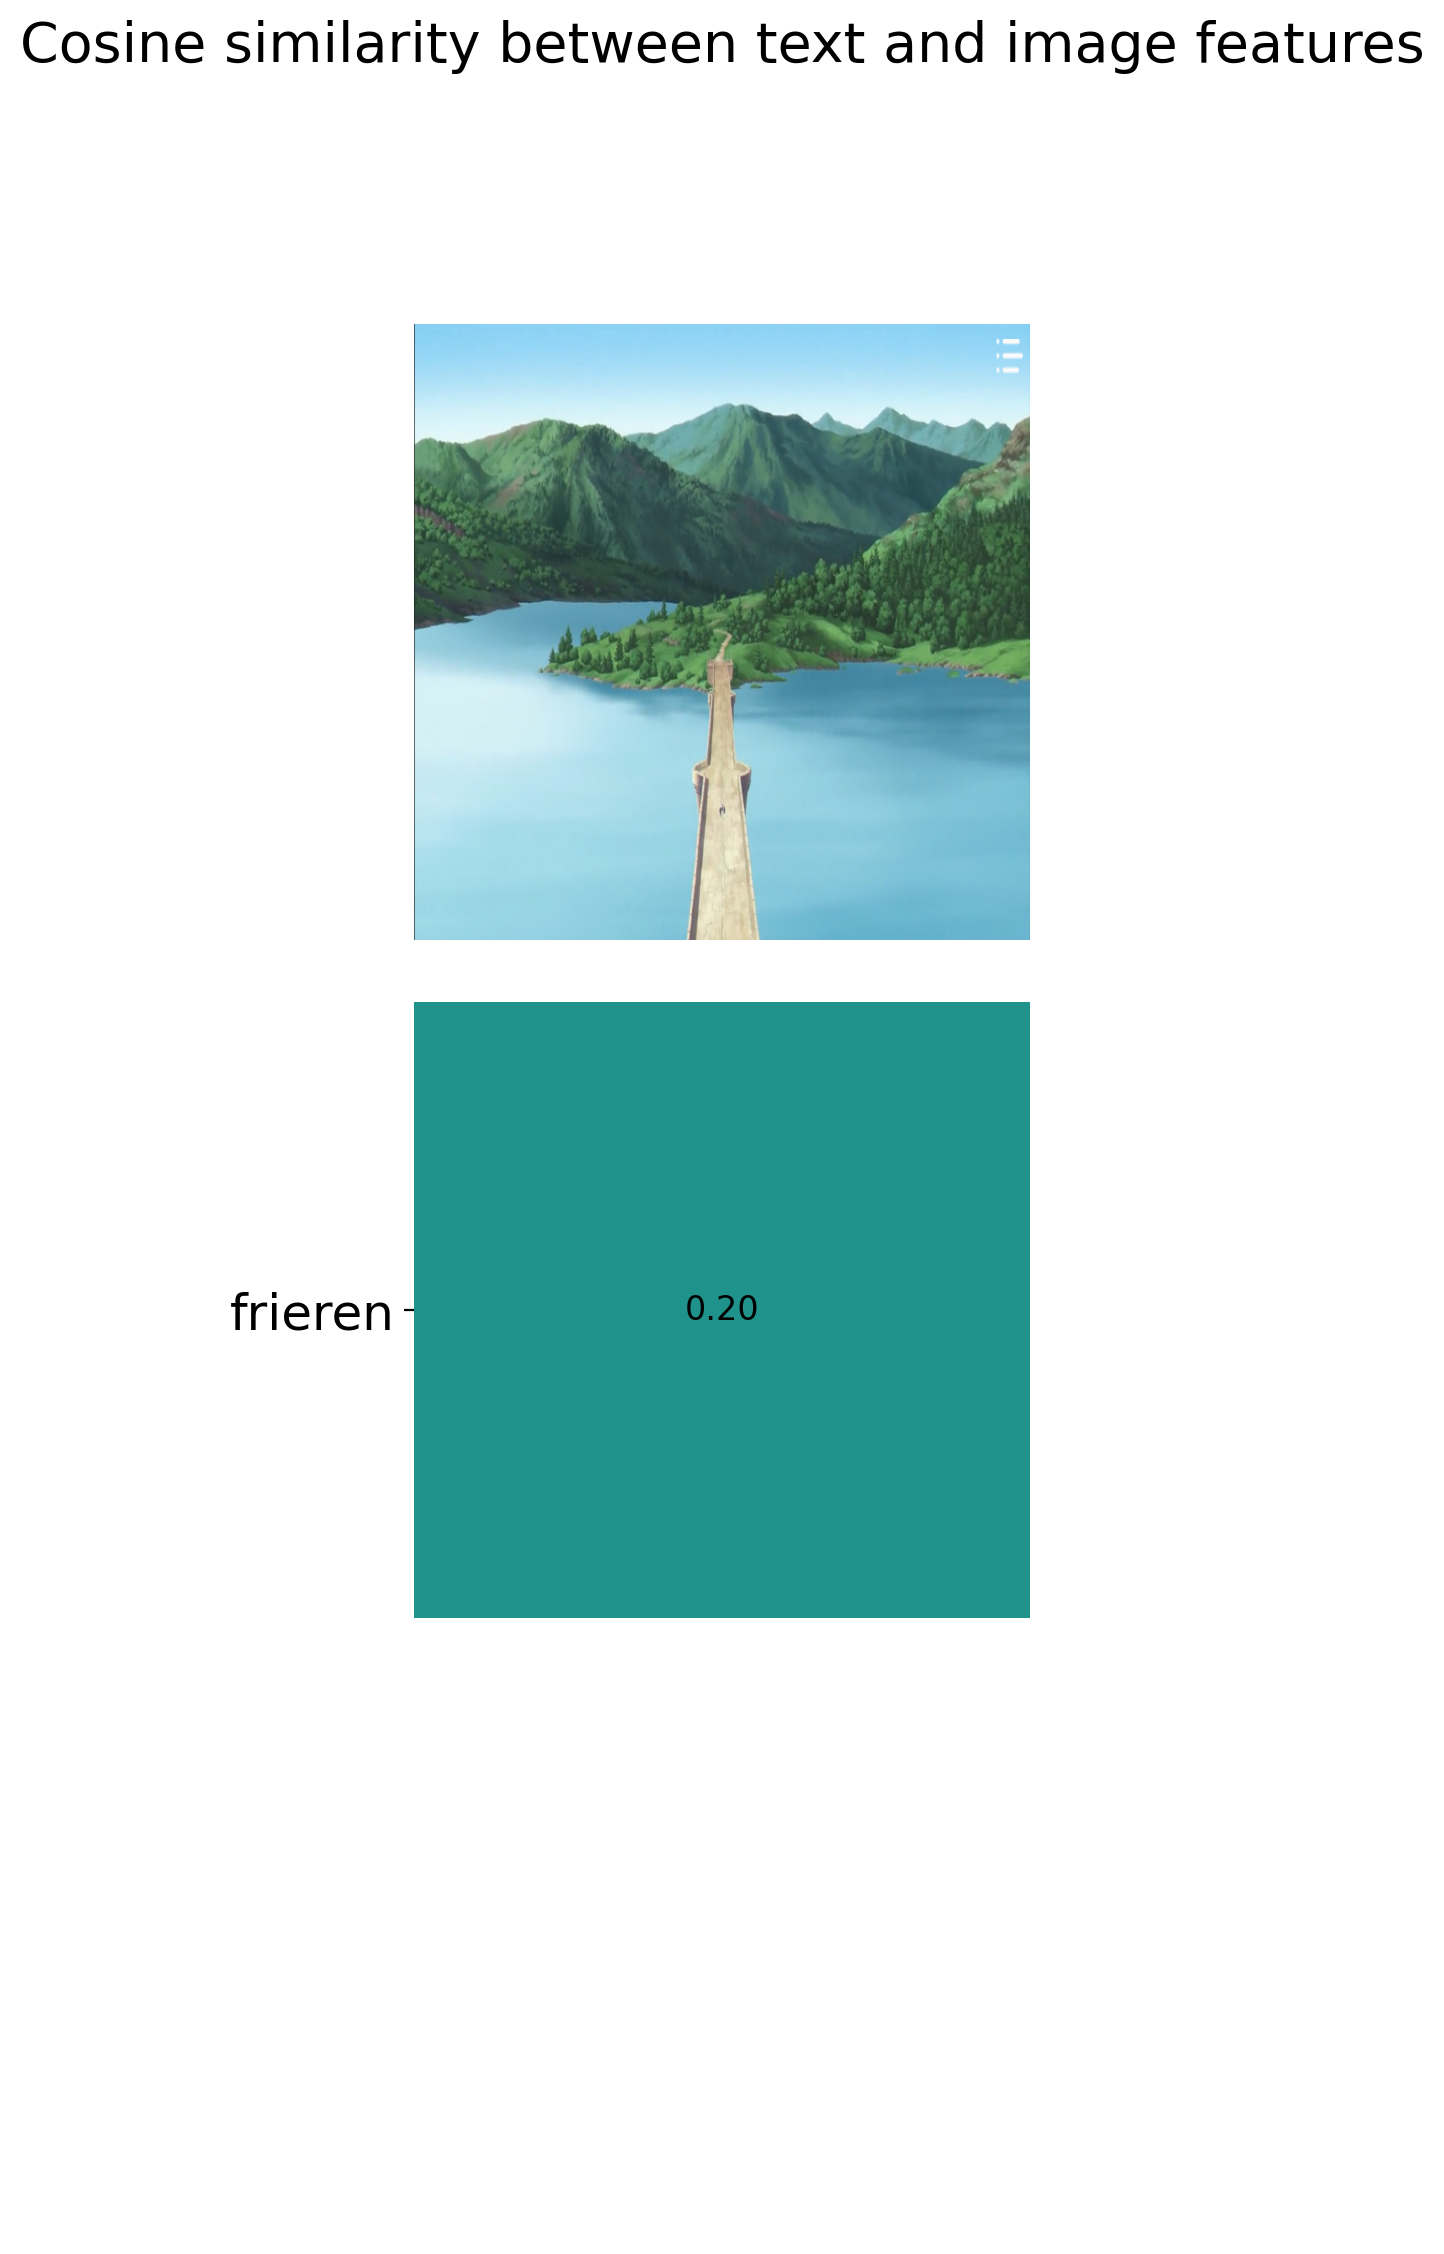

In [22]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)